In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
BASE_PATH="/content/drive/MyDrive/Colab Notebooks/transformers_practice"

In [4]:
# Load packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

RANDOM_STATE=33

# Read Data

In [5]:
anime_data = pd.read_csv(BASE_PATH + "/dataset/anime_dataset.csv")

In [6]:
anime_data.head(1)

,Anime_id,Title,Genre,Synopsis,Type,Producer,Studio,Rating,ScoredBy,Popularity,Members,Episodes,Source,Aired,Link
0,1,Cowboy Bebop,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...","In the year 2071, humanity has colonized sever...",TV,['Bandai Visual'],['Sunrise'],8.81,363889.0,39.0,704490.0,26.0,Original,"Apr 3, 1998 to Apr 24, 1999",https://myanimelist.net/anime/1/Cowboy_Bebop


In [7]:
anime_synopsis_column_name = "Synopsis"
anime_genre_column_name = "Genre"

In [8]:
len(anime_data)

17002

In [9]:
print(anime_data[anime_genre_column_name].isnull().sum())
print(anime_data[anime_synopsis_column_name].isnull().sum())

2012
1419


In [10]:
anime_data.drop(anime_data[anime_data[anime_synopsis_column_name].isnull()].index, inplace=True)
anime_data.drop(anime_data[anime_data[anime_genre_column_name].isnull()].index, inplace=True)

In [11]:
print(anime_data[anime_genre_column_name].isnull().sum())
print(anime_data[anime_synopsis_column_name].isnull().sum())

0
0


In [12]:
len(anime_data)

13743

In [13]:

def remove_out_brackets(x):
    x=x.split(",")
    nospace=[]
    for item in x:
        item=item.replace("[","")
        item=item.replace("]","")
        nospace.append(item)
    return (",").join(nospace)

def remove_quote_mark(x):
    x=x.split(",")
    nospace=[]
    for item in x:
        item=item.replace("'","")
        nospace.append(item)
    return (",").join(nospace)

In [14]:
anime_data[anime_genre_column_name]=anime_data[anime_genre_column_name].apply(remove_out_brackets)
anime_data[anime_genre_column_name]=anime_data[anime_genre_column_name].apply(remove_quote_mark)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
label_vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary=True)
label_vectorizer.fit(anime_data[anime_genre_column_name])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(binary=True, tokenizer=<function <lambda> at 0x7f57ae548700>)

In [16]:
labels = label_vectorizer.get_feature_names_out()

In [17]:
print(len(labels))

82


In [18]:
all_labels = label_vectorizer.transform(anime_data[anime_genre_column_name]).toarray()

In [19]:
print(all_labels)

[[1 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Train, validation, test split

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(anime_data[anime_synopsis_column_name],\
                                                    all_labels, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [21]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(8245,)
(2749,)
(2749,)
(8245, 82)
(2749, 82)
(2749, 82)


synopsis max length : 2645
average synopsis length : 400.2853850818678


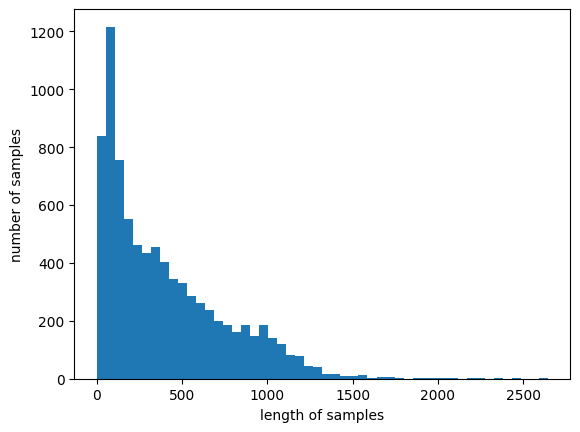

In [22]:
print('synopsis max length :',max(len(review) for review in X_train))
print('average synopsis length :',sum(map(len, X_train))/len(X_train))
avg = sum(map(len, X_train))/len(X_train)
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
# It seems that we need to use the max length for our bert tokenizer
# However making the max length to 512 is too big! Which can cause gpu RAM to run out

# BERT Tokenizer

In [23]:
import tensorflow_hub as hub
from tensorflow.keras import Model
from transformers import BertTokenizer, TFAutoModel

In [24]:
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

In [25]:
X_train

8718     Former members of the idol group IKB31, Ayaka ...
200      Kousuke is a high school student. He just rece...
4134     In a town where discrimination based on colors...
6074     The film takes place in 201X, when the newly-f...
5232     Rion gets tricked into installing a chip into ...
                               ...                        
6791                       A 1967 Korean historical movie.
466      Even after death, life is full of paperwork an...
13734    Will G.G. Bond be able to save Fairy World whe...
14191    A collaboration between  Aware! Meisaku-kun  a...
9520     As a new student, Eruna Ichinomiya meets vario...
Name: Synopsis, Length: 8245, dtype: object

In [26]:
tokenizer_max_length = 100

In [27]:
X_train_tokens = tokenizer(X_train.tolist(), padding="max_length", truncation=True, return_tensors="tf", max_length=tokenizer_max_length)
X_val_tokens = tokenizer(X_val.tolist(), padding="max_length", truncation=True, return_tensors="tf", max_length=tokenizer_max_length)
X_test_tokens = tokenizer(X_test.tolist(), padding="max_length", truncation=True, return_tensors="tf", max_length=tokenizer_max_length)

In [28]:
X_train_tokens

{'input_ids': <tf.Tensor: shape=(8245, 100), dtype=int32, numpy=
array([[  101,  2280,  2372, ...,  3947,  2000,   102],
       [  101, 12849,  2271, ...,  2005,  2169,   102],
       [  101,  1999,  1037, ...,  2169,  2060,   102],
       ...,
       [  101,  2097,  1043, ...,     0,     0,     0],
       [  101,  1037,  5792, ...,  3527,  3573,   102],
       [  101,  2004,  1037, ...,  1997,  1037,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(8245, 100), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(8245, 100), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=in

# Create Model

In [29]:
bert = TFAutoModel.from_pretrained(bert_model_name)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [30]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [31]:
from sklearn.metrics import accuracy_score

def get_accuracy(y, y_pred):
    acc = []
    for i,j in zip(y, y_pred):
        acc.append(accuracy_score(i,j))
    return np.mean(acc)

def accuracy(y, y_pred):
    return tf.py_function(get_accuracy, (y, tf.cast((y_pred>0.5), tf.float32)), tf.double)

In [33]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input, Dropout
from tensorflow.keras import optimizers


def build_multi_label_model(max_len, labels_len):
  input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
  input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

  embeddings = bert(input_ids, attention_mask = input_mask)[0] # 0 - last hidden_state
  # X = tf.keras.layers.Dropout(0.2)(embeddings)
  # pooled_output = Dropout(embeddings[1])
  gpa = GlobalAveragePooling1D()(embeddings)
  output_layer = Dense(units=labels_len, activation='sigmoid')(gpa)
  model = Model(inputs=[input_ids, input_mask], outputs=output_layer)
  model.summary()


  return model

In [34]:
multi_label_model = build_multi_label_model(tokenizer_max_length, len(labels))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [35]:
from keras.optimizers import Adam
metrics = [accuracy]
multi_label_model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),\
                          loss='binary_crossentropy', metrics=metrics)

In [37]:
history = multi_label_model.fit({'input_ids': X_train_tokens['input_ids'],\
                                   'attention_mask': X_train_tokens['attention_mask']},\
                                  y_train,
                                  epochs=2,
                                  batch_size=32,
                                  validation_data=({\
                                      'input_ids': X_val_tokens['input_ids'],\
                                      'attention_mask': X_val_tokens['attention_mask']\
                                  }, y_val)
                                  )

Epoch 1/2
258/258 [==============================] - 241s 936ms/step - loss: 0.1086 - accuracy: 0.9666 - val_loss: 0.1034 - val_accuracy: 0.9675
Epoch 2/2
258/258 [==============================] - 220s 852ms/step - loss: 0.0965 - accuracy: 0.9688 - val_loss: 0.1002 - val_accuracy: 0.9678


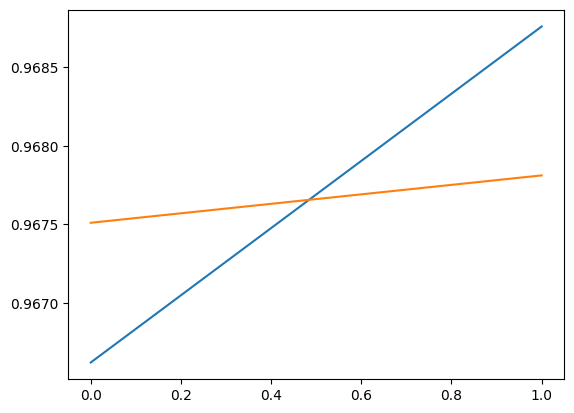

In [39]:
df_metric = pd.DataFrame()
df_metric['epoch'] = np.arange(len(history.history['loss']))
df_metric['loss'] = history.history['loss']
df_metric['val_loss'] = history.history['val_loss']
df_metric['accuracy'] = history.history['accuracy']
df_metric['val_accuracy'] = history.history['val_accuracy']

plt.plot(df_metric['epoch'], df_metric['accuracy'])
plt.plot(df_metric['epoch'], df_metric['val_accuracy'])
plt.show()

In [63]:
from sklearn.metrics import accuracy_score

y_pred = (multi_label_model.predict({'input_ids': X_test_tokens['input_ids'],\
                                   'attention_mask': X_test_tokens['attention_mask']})>0.5)*1
acc = [accuracy_score(i,j) for i,j in zip(y_pred, y_test)]
idx = np.argsort(acc)[::-1]

86/86 [==============================] - 21s 239ms/step


In [65]:
def show(i):
    # print(f'movie: {X_test[i]}')
    # print(f'description: {X_test.text.values[i]}')

    # y_act_idx = unique[np.where(y_test[i]==1)]
    # y_pred_idx = unique[np.where(y_pred[i]==1)]
    print(f'metric score: {acc[i]}')
    print(f'description: {X_test.values[i]}')
    test_labels = label_vectorizer.inverse_transform([y_test[i]])
    pred_labels = label_vectorizer.inverse_transform([y_pred[i]])
    print(f'actual genre: {" ".join(str(x) for x in test_labels)}')
    print(f'predicted genre: {" ".join(str(x) for x in pred_labels)}')
    print('\n', '*'*50, '\n')
    
for i in idx[:5]:
    show(i)

metric score: 1.0
description: Music video directed by Mitsuyuki Ishibashi for the song  HYPER SWEET POWER  by TsuShiMaMiRe (TSMMR). It was produced by Cartoon Network Japan for the 10th anniversary of  The Powerpuff Girls  in 2008.
actual genre: ['music']
predicted genre: ['music']

 ************************************************** 

metric score: 1.0
description: Based on the first Wizardry game "The Proving Grounds of the Mad Overlord", a group of characters enter a dungeon to confront the ultimate wizard to prevent him from reaching an unstoppable power. On their way they meet up with a few new friends who have their own battles to settle, but their paths lay together. 
 
(Source: ANN)
actual genre: [' adventure' ' fantasy' 'action']
predicted genre: [' adventure' ' fantasy' 'action']

 ************************************************** 

metric score: 1.0
description: Official music video for the song  Muteki We Are One!!  by the fictional band  Irodorimidori . It is the 7th son

In [76]:
def classify_text(plot):
  tokens = tokenizer([plot], padding="max_length", \
                     truncation=True, return_tensors="tf", max_length=tokenizer_max_length)
  pred = (multi_label_model.predict({'input_ids': tokens['input_ids'],\
                                   'attention_mask': tokens['attention_mask']})>0.1)*1
  pred_labels = label_vectorizer.inverse_transform([pred[0]])
  return pred_labels


In [79]:
print(classify_text("People come out of the town to defend their village. Among the people who escaped, there was a girl"))

1/1 [==============================] - 0s 133ms/step
[array([' music', 'music'], dtype='<U14')]


In [78]:
multi_label_model.save("multi_genre_classify.h5")